In [1]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Torch float precision
torch.set_default_dtype(torch.float64)

# Plotting style
sns.set_style('darkgrid')
sns.set_theme(font_scale=1.)

## Example: Geometry-Aware Brownian Motion in the Latent Space of an Autoencoder
As detailed in the manuscript, it is straight-forward to add Brownian motion on learnt data manifolds by pulling back the geometry to a known parameter space of the manifold. In this example, we will show how to do so when the data manifold is approximated by an *autoencoder*. 

In this setting, we consider the latent space $\mathbb{R}^d$ as the parameter space and define the data manifold using the decoder $f_d: \mathbb{R}^d \rightarrow \mathbb{R}^D$ as the chart. We show how to make geometry-aware perturbations of data points using this setup, specifically for the well-known MNIST image dataset from which we can easily draw qualitative conclusions on how the strategy works.

We proceed by loading the dataset.

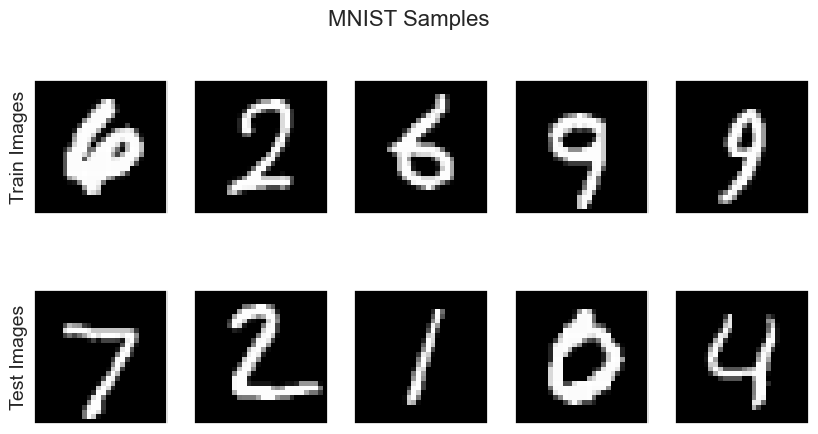

In [2]:
from train_mnist_autoencoder import get_loaders

# Set random seed for reproducibility
torch.manual_seed(0)

# Get the data loaders
train_loader, test_loader = get_loaders(batch_size=10)

# Extract some example training and test images
train_images, train_labels = next(iter(train_loader))
test_images, test_labels = next(iter(test_loader))

# Plot a few test and training images
fig, axs = plt.subplots(2, 5, figsize=(10, 5), sharex=True, sharey=True)
for i in range(5):
    axs[0, i].imshow(train_images[i].squeeze(), cmap='gray')
    axs[1, i].imshow(test_images[i].squeeze(), cmap='gray')
    axs[0, i].grid(False)
    axs[1, i].grid(False)
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
axs[0, 0].set_ylabel('Train Images', fontsize=14)
axs[1, 0].set_ylabel('Test Images', fontsize=14)
plt.suptitle('MNIST Samples', fontsize=16)
plt.show()

We train an autoencoder on the training set. This model type works by encoding an image $\boldsymbol{x}$ to a latent representation $\boldsymbol{z}$ using an encoder $f_e: \mathbb{R}^D \rightarrow \mathbb{R}^d$. Next, the latent representation is decoded with a decoder $f_d: \mathbb{R}^d \rightarrow \mathbb{R}^D$ to get a reconstruction of the image, hence $\hat{\boldsymbol{x}} = f_d\left(f_e\left(\boldsymbol{x}\right)\right)$. For the MNIST digits dataset $D=28\times 28 = 784$.

We "cheated" a bit by training an autoencoder with a $d=16$ dimensional latent space based on a convolutional decoder and encoder prior to running this example. This can easily be done by running the script `train_mnist_autoencoder.py`. In the following, we load a pre-trained model checkpoint and visualize how the autoencoder reconstructs the training and test images shown above.

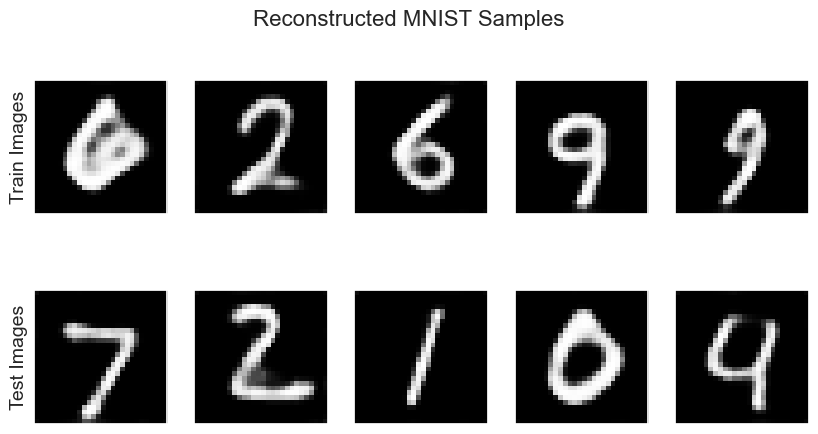

In [3]:
from train_mnist_autoencoder import ConvolutionalAutoencoder

# Define checkpoint path
checkpoint_path = f'./results/best.pth'
device = 'cpu'

# Load the trained autoencoder model
model = ConvolutionalAutoencoder()
model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device(device), weights_only=True))
model.eval()

# Reconstruct training and test images
with torch.no_grad():
    reconstructed_train, _ = model(train_images)
    reconstructed_test, _ = model(test_images)

# Plot a few test and training images
fig, axs = plt.subplots(2, 5, figsize=(10, 5), sharex=True, sharey=True)
for i in range(5):
    axs[0, i].imshow(reconstructed_train[i].squeeze(), cmap='gray')
    axs[1, i].imshow(reconstructed_test[i].squeeze(), cmap='gray')
    axs[0, i].grid(False)
    axs[1, i].grid(False)
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
axs[0, 0].set_ylabel('Train Images', fontsize=14)
axs[1, 0].set_ylabel('Test Images', fontsize=14)
plt.suptitle('Reconstructed MNIST Samples', fontsize=16)
plt.show()

#### Defining the Manifold

The `Manifold` class included in the code toolbox allows for easily constructing manifolds that have a parametrisation. In fact, all we need to do is to make a subclass and define the `__call__`-method accordingly. In the case of the autoencoder, the chart from parameter space to the manifold is fully given by the decoder, i.e. $X := f_d$ and the latent representations are considered the intrisic parameters of the manifold. We show how to define this manifold in the following cell. 

In [4]:
from geometric_noise.manifolds.manifold import Manifold

torch.set_default_dtype(torch.float32)

class ImageManifold(Manifold):
    def __init__(self, checkpoint, device, return_torch=True):
        super().__init__(return_torch=return_torch)

        # Define the autoencoder here
        self.autoencoder = ConvolutionalAutoencoder()
        self.autoencoder.load_state_dict(torch.load(checkpoint, weights_only=True))
        self.autoencoder.to(device)
        self.autoencoder.eval()

    def __call__(self, latent_representation):
        with torch.no_grad():
            self.autoencoder.eval()
            # Decode the latent representation
            out = self.autoencoder.decoder(latent_representation)
            if not self.autoencoder.use_sigmoid:
                # Rescale to [0, 1]
                out = (out + 1) / 2  
            return out

Given this definition, we inherit all the geometric tools from the `Manifold` class, e.g. how to compute the metric: 

In [5]:
# Define the manifold
manifold = ImageManifold(checkpoint=checkpoint_path, device=device)

# Compute the metric tensor at a random point in the latent space
z = torch.randn((1, 16))  # Assuming latent dimension is 16
g = manifold.metric(z)
print("Metric tensor shape:", g.shape)

Metric tensor shape: torch.Size([16, 16])


#### Sampling noisy observations through Brownian motion

Now that we have the manifold class, we can easily generate a Brownian motion on the approximated data manifold using the `.brownian_motion()`-method of the class. In the following cell we:

1) choose a specific example image $\boldsymbol{x}$ and get its latent representation $\boldsymbol{z}$,
2) run $S=100$ different Brownian motion chains from this example to get a set of geometry-aware noisy samples $\{\hat{x}_i\}_{i=1}^S$,
3) equivalently, generate $S=100$ noisy versions of the digit by adding Gaussian noise in the ambient space as well as on the latent representation.

In [6]:
torch.manual_seed(42)

# Choose image example
example_idx = 3
example_img = test_images[example_idx]
example_repr = manifold.autoencoder.encoder(example_img.unsqueeze(0).to(device))

# Parameters for the Brownian motion
noise_intensity = 1
num_trajs = 100
num_steps = 100

# Run Brownian motions
img_trajectories, latent_trajectories = torch.vmap(lambda x: manifold.brownian_motion(x, diffusion_time=noise_intensity, num_steps=num_steps, return_trajectories=True), randomness='different')(example_repr.repeat(num_trajs, 1))
latent_trajectories = latent_trajectories.squeeze(2)

# Add ambient space noise to the original image for comparison
noisy_imgs = example_img + torch.randn_like(example_img.flatten().repeat((num_trajs, 1)).reshape((num_trajs, 28, 28))) * np.sqrt(noise_intensity)
noisy_imgs = torch.clip(noisy_imgs, 0., 1.)

# Add noise in latent space and decode
noisy_reprs = manifold.autoencoder.decoder(example_repr + torch.randn_like(example_repr.flatten().repeat((num_trajs, 1))) * np.sqrt(noise_intensity)).squeeze(1).detach()

We compute the pixel-wise variation over the $S=100$ samples of both ambient Gaussian noise and intrinsic Brownian motion noise and visualize the result.

/var/folders/0k/7rppf3_51sb5rpp5p580nxn028z2ts/T/ipykernel_28402/843245319.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


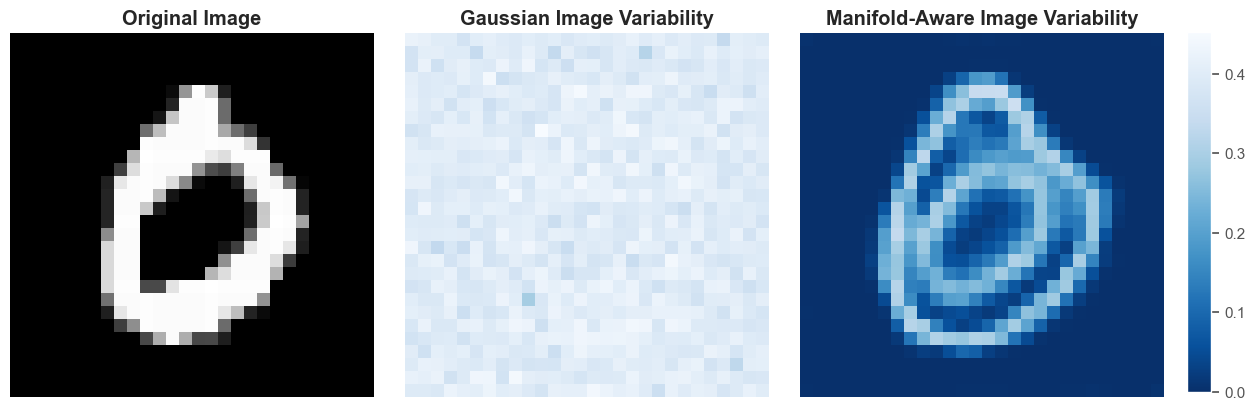

In [7]:
# Compute std deviations per pixel
std_gaussian = noisy_imgs.std(dim=0).squeeze(0)
std_bm = img_trajectories[:, -1, 0, 0, :, :].std(dim=0)

# Put them on the same scale
vmin, vmax = min(std_gaussian.min(), std_bm.min()), max(std_gaussian.max(), std_bm.max())

# Plot the variation per pixel with the original image
fig, axs = plt.subplots(1, 3, figsize=(12,4))
img = axs[0].imshow(example_img.reshape(28, 28), cmap='gray')
img = axs[1].imshow(std_gaussian, cmap='Blues_r', vmin=vmin, vmax=vmax)
img = axs[2].imshow(std_bm, cmap='Blues_r', vmin=vmin, vmax=vmax)

# Add colorbar
cax = fig.add_axes([1.0, 0.05, 0.02, 0.9])  # x, y, width, height
fig.colorbar(img, cax=cax)

# Set titles and remove axes
axs[0].set_title('Original Image', fontweight='bold')
axs[1].set_title(r'Gaussian Image Variability', fontweight='bold')
axs[2].set_title(r'Manifold-Aware Image Variability', fontweight='bold')
axs[0].axis(False)
axs[1].axis(False)
axs[2].axis(False)

plt.tight_layout()

import os
os.makedirs('figures', exist_ok=True)
plt.savefig(f'figures/mnist_variability_noise={noise_intensity}.svg', bbox_inches='tight', dpi=300)
plt.show()

We also visualize some of the generated noise samples below. This reveals that our Brownian motion strategy clearly adds noise only to relevant parts of image that distorts the digit in a natural way, where the signal (digit) is lost in ambient Gaussian noise when the noise intensity is too large.

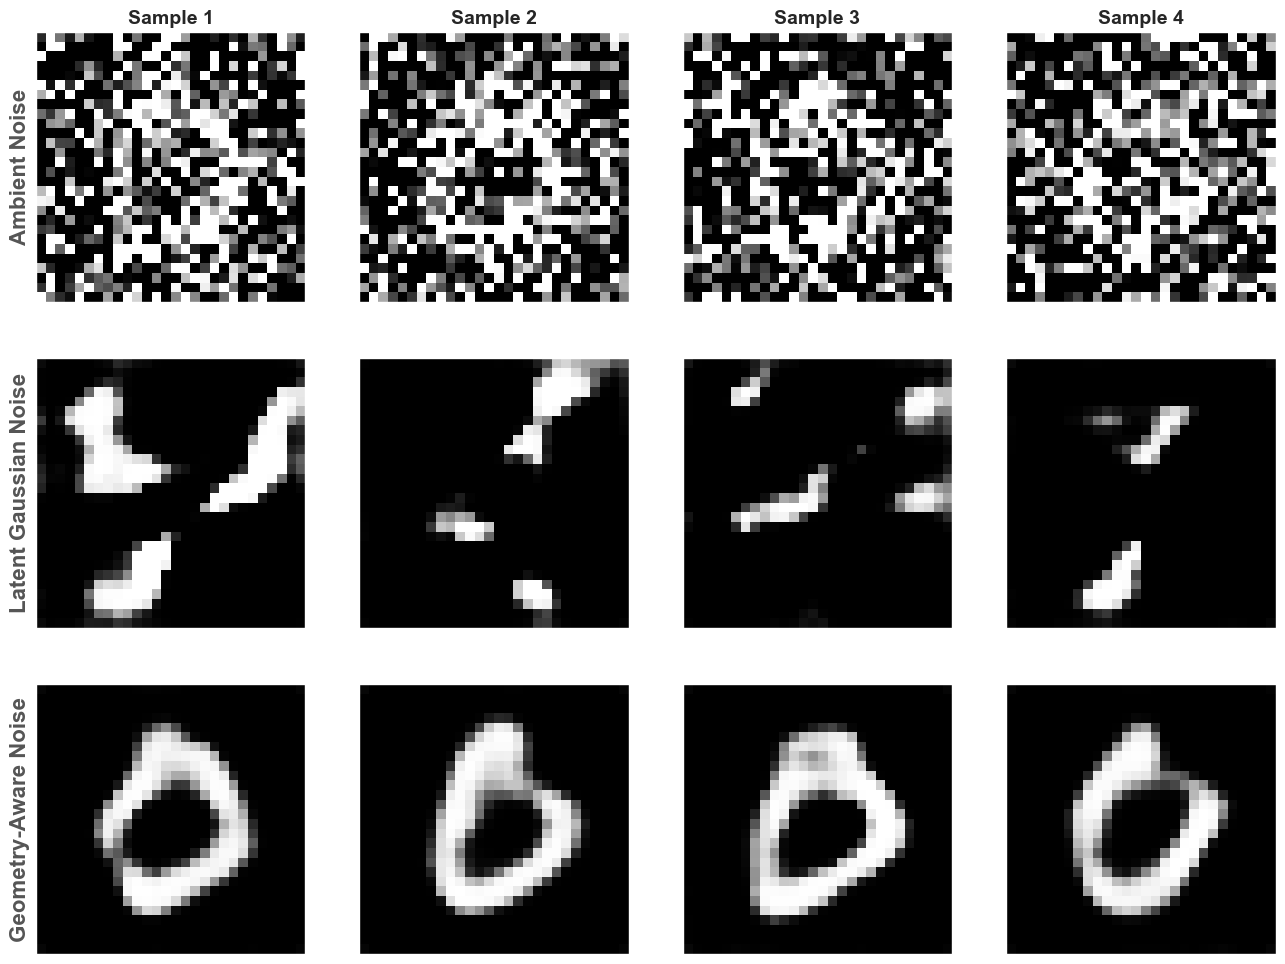

In [8]:
# Set the number of samples to display
n_samples = 4

# Plot samples from the three noise models
fig, axs = plt.subplots(3, n_samples, figsize=(n_samples * 4, 12), sharex=True, sharey=True)
for i in range(n_samples):
    axs[0, i].imshow(noisy_imgs[-i].cpu().reshape(28, 28).detach().numpy(), cmap='gray')
    axs[1, i].imshow(noisy_reprs[-i].cpu().reshape(28, 28).detach().numpy(), cmap='gray')
    axs[2, i].imshow(img_trajectories[-i, -1, 0, 0, :, :].cpu().reshape(28, 28).detach().numpy(), cmap='gray')
    axs[0, i].set_title(f'Sample {i+1}', fontsize=14, fontweight='bold')

axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])
axs[0, 0].grid(False)

axs[0, 0].set_ylabel('Ambient Noise', fontsize=16, fontweight='bold')
axs[1, 0].set_ylabel('Latent Gaussian Noise',  fontsize=16, fontweight='bold')
axs[2, 0].set_ylabel('Geometry-Aware Noise',  fontsize=16, fontweight='bold')

plt.savefig(f'figures/mnist_noisy_samples={noise_intensity}.svg', bbox_inches='tight', dpi=300)
plt.show()



# Set the number of samples to display
n_samples = 4
# Plot samples from the three noise models
fig, axs = plt.subplots(2, n_samples, figsize=(n_samples * 4, 8), sharex=True, sharey=True)
for i in range(n_samples):
    axs[0, i].imshow(noisy_imgs[-i].cpu().reshape(28, 28).detach().numpy(), cmap='gray')
    axs[1, i].imshow(img_trajectories[-i, -1, 0, 0, :, :].cpu().reshape(28, 28).detach().numpy(), cmap='gray')
    axs[0, i].set_title(f'Sample {i+1}', fontsize=14, fontweight='bold')
axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])
axs[0, 0].grid(False)
axs[0, 0].set_ylabel('Ambient Noise', fontsize=16, fontweight='bold')
axs[1, 0].set_ylabel('Geometry-Aware Noise',  fontsize=16, fontweight='bold')
plt.savefig(f'figures/mnist_noisy_samples={noise_intensity}.svg', bbox_inches='tight', dpi=300)
plt.close()

We include a small animation for illustrating the stochastic process of noise addition when following either the ambient Gaussian noise (which is standard Brownian motion in the ambient space) or the geometry-aware Brownian motion strategy.

In [9]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

save_animation = False  # Set to True to save the animation as mp4 and gif files

# Animate over the time dimension of the first trajectory
num_steps = img_trajectories.shape[1]
dt = noise_intensity / num_steps

# Define noise increments for reference
increments = torch.randn((num_trajs, num_steps, 28, 28), device=device) * np.sqrt(dt)
increments[:, 0, :, :] = torch.zeros((num_trajs, 28, 28), device=device)  # First increment is zero
cum_increments = torch.cumsum(increments, dim=1)

# Plot the first n_samples trajectories
fig, axs = plt.subplots(2, n_samples, figsize=(n_samples*4, 8), sharex=True, sharey=True)
frame0 = img_trajectories[:n_samples, 0, 0, 0, :, :].cpu().numpy()
g_ims, ims = [], []
for i in range(n_samples):
    g_im = axs[0, i].imshow(example_img.squeeze(0), cmap='gray', vmin=0., vmax=1.)
    title = axs[0, i].set_title(f'Sample {i+1}', fontsize=14)
    g_ims.append(g_im)

    im = axs[1, i].imshow(frame0[i], cmap='gray', vmin=0., vmax=1.)
    title = axs[1, i].set_title(f'Sample {i+1}', fontsize=14)
    ims.append(im)

    for c in range(2):
        axs[c, i].set_xticks([])
        axs[c, i].set_yticks([])
        axs[c, i].grid(False)

axs[0, 0].set_ylabel('Ambient noise', fontsize=16, fontweight='bold')
axs[1, 0].set_ylabel('Geometry-Aware noise', fontsize=16, fontweight='bold')

def update(frame):
    data = img_trajectories[:n_samples, frame, 0, 0, :, :].cpu().numpy()
    for i, im in enumerate(ims):
        im.set_data(data[i])
    
    for i, g_im in enumerate(g_ims):
        g_im.set_data(torch.clip(example_img + cum_increments[i, frame, :, :].cpu(), 0., 1.).squeeze(0))

    fig.suptitle(f'Step {frame+1}', fontsize=16, fontweight='bold')
    
    return tuple(ims + g_ims)

anim = FuncAnimation(fig, update, frames=num_steps, interval=100, blit=True)
plt.close(fig)  # Prevent duplicate static output

if save_animation:
    from matplotlib.animation import FFMpegWriter
    writer = FFMpegWriter(fps=10, metadata=dict(artist='auto'), bitrate=1800)
    anim.save('figures/mnist_noise_animation.mp4', writer=writer, dpi=150)
    anim.save('figures/mnist_noise_animation.gif', writer='pillow', fps=10)

# Display inline in the notebook
HTML(anim.to_jshtml())

## Improving classification performance using geometry-aware noise

Next, we use the two strategies in the training loop when learning to classify the images of digits. Again, we "cheated" by running the experiment beforehand using the `train_mnist_classifier.py` script. 

In the below, we show the results obtained when training a 1-layer MLP with $1024$ hidden units. We examine 4 scenarios where the training data used for training the classifier has been subsampled to $1\%$, $10\%$ and $50\%$ as well as the case of using the full training data set. Results are based on training both the autoencoder and classifier over $10$ different random initializations from which we get uncertainty of the model performances. The key take-aways are:
1) learning with geometry-aware input noise can improve generalisation capabilities in highly overparametrised settings.
2) performance is more robust to geometry-aware noise injection than Gaussian noise injection that increasingly breaks the fit.
3) the geometry-aware strategy has less effect when increasing the amount of training data considered and does not necessarily perform better than a model trained only on the original images. 

The latter is likely due to a quality gap between reconstructed and original images and we note that our proposed strategy improves over training without augmentation on the reconstructions. This could suggest that our method would also perform better than the original model in case the autoencoder had learnt to perfectly fit the data manifold.

In [10]:
n_classes = 10
hidden_dim = 1024

model = torch.nn.Sequential(
    torch.nn.Linear(28*28, hidden_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_dim, n_classes),
)

print(f"Number of parameters: {sum([p.numel() for p in model.parameters()])}")

Number of parameters: 814090


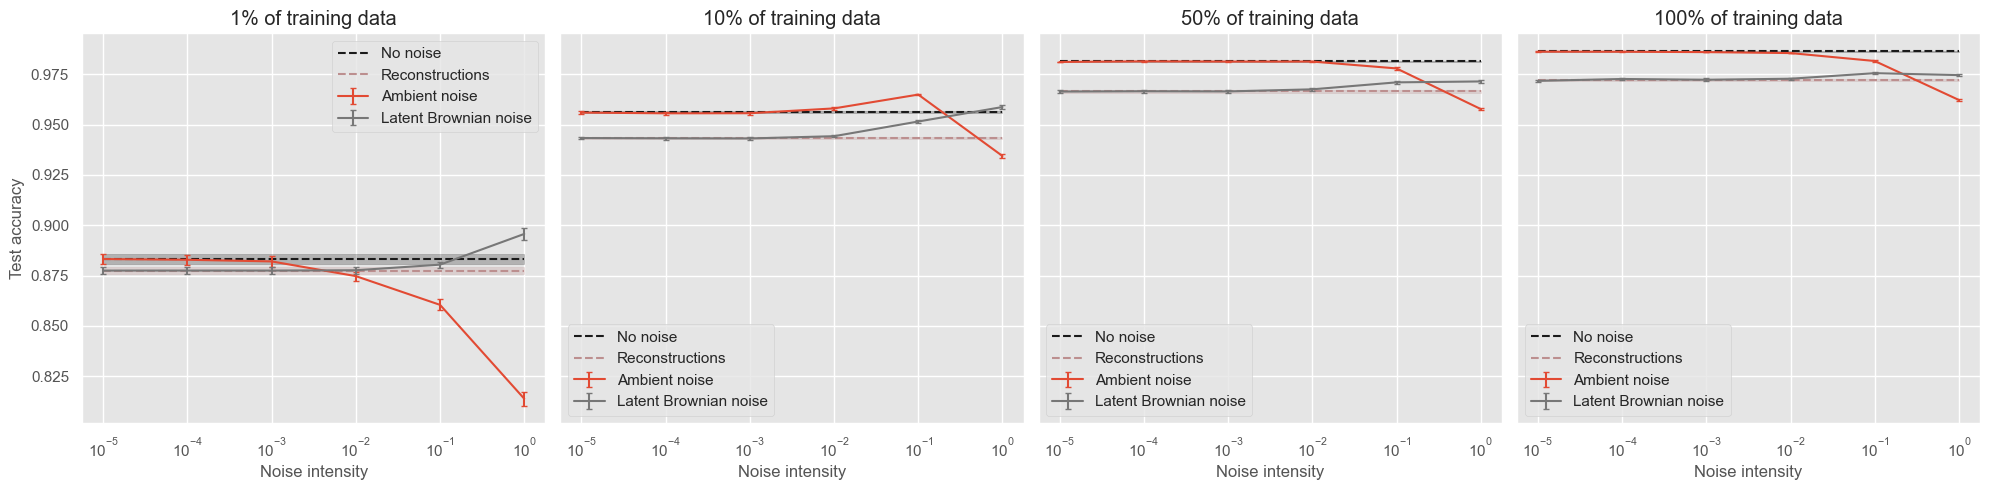

In [11]:
import pandas as pd

all_results = pd.read_csv('./results/results.csv')
all_results = all_results.query('noise_intensity < 10.0')
unique_fractions = len(all_results.subsample_fraction.unique())

colors = {'ambient': 'C0', 'brownian': 'C3'}

fig, axs = plt.subplots(1, unique_fractions, figsize=(5 * unique_fractions, 5), sharey=True)
for i, (fraction, sub_df) in enumerate(all_results.groupby('subsample_fraction')):
    # Group by method and noise intensity within each subsample fraction
    group = sub_df.groupby(by=['method', 'noise_intensity'])

    # Compute mean and SEM for each group
    avg = group.mean()
    sem = group.sem()

    # Plot the average test accuracy with error bars
    for method in sub_df['method'].unique():
        method_avg = avg.loc[method]
        method_sem = sem.loc[method]

        if method in ['standard', 'reconstructed']:
            label = 'No noise' if method == 'standard' else 'Reconstructions'
            color = 'k' if method == 'standard' else 'rosybrown'

            min_noise = sub_df.query('noise_intensity > 0')['noise_intensity'].min()
            max_noise = sub_df.query('noise_intensity > 0')['noise_intensity'].max()

            axs[i].hlines(method_avg['test_accuracy'].values, min_noise, max_noise, color=color, linestyles='dashed', label=label)
            axs[i].fill_between(
                [min_noise, max_noise],
                method_avg['test_accuracy'].values - method_sem['test_accuracy'].values,
                method_avg['test_accuracy'].values + method_sem['test_accuracy'].values,
                color=color, alpha=0.25)
        else:
            label = 'Ambient noise' if method == 'ambient' else 'Latent Brownian noise'
            axs[i].errorbar(method_avg.index, method_avg['test_accuracy'], yerr=method_sem['test_accuracy'], marker='', label=label, capsize=2, color=colors.get(method, 'C1'))

    axs[i].set_title(f'{fraction*100:.0f}% of training data')
    axs[i].set_xlabel('Noise intensity')
    if i == 0:
        axs[i].set_ylabel('Test accuracy')
    axs[i].set_xscale('log')
    axs[i].legend()

plt.tight_layout()
plt.savefig(f'figures/mnist_accuracy_comparison.svg', bbox_inches='tight', dpi=300)
plt.show()

#### Caveat: geometry-aware Brownian motion might cross class-borders

During experimentation, we observed qualitatively that the geometry-aware noise injection strategy can sometimes generate noisy observation that visually resemble other digits than the label they had originally attached. This happens because the autoencoder has no direct notion of the class labels, hence, this is also not captured when pulling back the geometry to the latent space. We experimented with including the classifier predictions as part of the chart (i.e. along with the decoder), yet, we did not see any significant performance gain and chose to stay with the simpler approach.

Below, we show exactly one of these scenarios, where the original digit $4$ is slowly transforming into something that visually resembles a $9$, which could end up confusing the classifier during training.

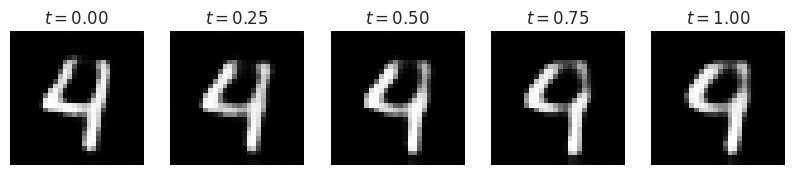

In [12]:
torch.manual_seed(42)

# Choose image example
example_idx = 4
example_img = test_images[np.arange(len(test_labels))[test_labels == 4][example_idx]]
example_repr = manifold.autoencoder.encoder(example_img.unsqueeze(0).to(device))

# Parameters for the Brownian motion
noise_intensity = 1
num_trajs = 20
num_steps = 1000

# Run Brownian motions
img_trajectories, latent_trajectories = torch.vmap(lambda x: manifold.brownian_motion(x, diffusion_time=noise_intensity, num_steps=num_steps, return_trajectories=True), randomness='different')(example_repr.repeat(num_trajs, 1))
latent_trajectories = latent_trajectories.squeeze(2)

# Plot the trajectory of a single example
every_i = 250
frames = img_trajectories[15, list(np.arange(0, num_steps, every_i)) + [num_steps - 1], 0, 0, :, :]
fig, axs = plt.subplots(1, len(frames), figsize=(len(frames) * 2, 2), sharex=True, sharey=True)
for i, img in enumerate(frames):
    axs[i].set_title(f'Step {i*every_i}', fontsize=12)
    axs[i].set_title(f'$t={i*every_i * (noise_intensity / num_steps):.2f}$', fontsize=12)
    axs[i].imshow(img.cpu().reshape(28, 28).detach().numpy(), cmap='gray')
    axs[i].axis('off')

plt.savefig(f'figures/mnist_bad_noise_example.svg', bbox_inches='tight', dpi=300)
plt.show()